In [561]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from tensorflow.keras import Sequential, layers
from tensorflow.keras import layers, losses, metrics, optimizers, regularizers
import math

In [562]:
data = pd.read_json("currency-best-chart.json")

In [563]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2663 entries, 0 to 2662
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2663 non-null   datetime64[ns]
 1   value0  2663 non-null   float64       
 2   value1  2663 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 62.5 KB


In [564]:
data

,date,value0,value1
0,2015-07-02,1.535,1.540
1,2015-07-03,1.535,1.540
2,2015-07-04,1.535,1.540
3,2015-07-05,1.535,1.540
4,2015-07-06,1.538,1.543
...,...,...,...
2658,2022-10-20,2.493,2.505
2659,2022-10-21,2.487,2.500
2660,2022-10-22,2.484,2.500
2661,2022-10-23,2.484,2.500


In [565]:
data = data[{'date','value0'}]

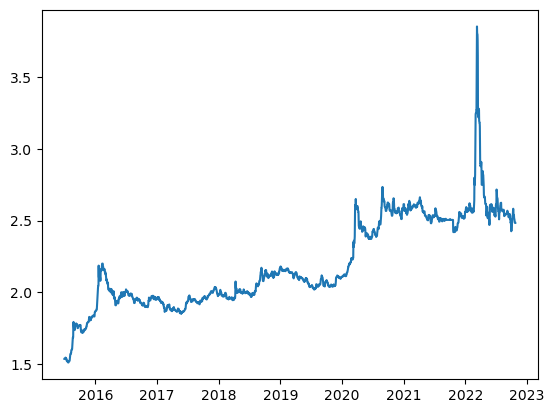

In [566]:
row = data.value0.values
plt.plot(data.date,row)
plt.show()

In [567]:
# нормализация данных
scaler = StandardScaler()
series_matrix = row.reshape(len(row), 1)
scaler.fit(series_matrix)
normalized_matrix = scaler.transform(series_matrix)

In [650]:
sequence_length = 50
regressor = Sequential([layers.LSTM(units = 25, activation='elu', input_shape = (1, sequence_length)),
                        layers.Dense(1, activity_regularizer=regularizers.l2(0.05))])

In [651]:
X = []
y = []
time_steps = len(normalized_matrix)
for i in range(time_steps - sequence_length):
    sequence = normalized_matrix[i:(i+sequence_length)]
    X.append(sequence)
    y.append(normalized_matrix[i+sequence_length])
X = np.array(X)
y = np.array(y)

In [652]:
time_steps = len(X)
training_time_steps = math.floor(time_steps * 0.5)
X_train = X[:training_time_steps]
X_test = X[training_time_steps:]
y_train = y[:training_time_steps]
y_test = y[training_time_steps:]

In [653]:
X_train_sequences = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_sequences = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [654]:
from livelossplot import PlotLossesKeras

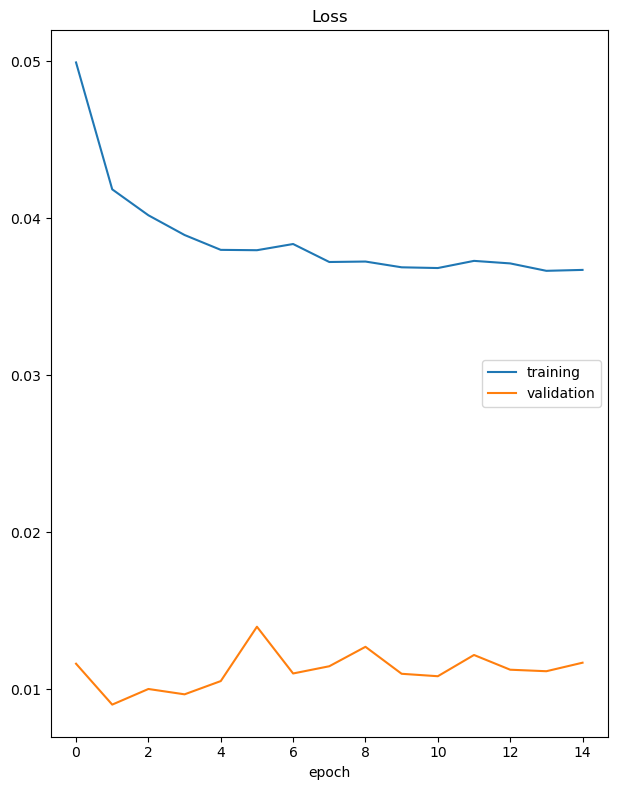

Loss
	training         	 (min:    0.037, max:    0.050, cur:    0.037)
	validation       	 (min:    0.009, max:    0.014, cur:    0.012)
33/33 [==============================] - 2s 56ms/step - loss: 0.0367 - val_loss: 0.0117


In [655]:
regressor.compile(loss=losses.mse, optimizer=optimizers.Adam(learning_rate=0.001))
regressor.fit(X_train_sequences, y_train, batch_size=32,epochs=15, validation_split=0.2,callbacks=[PlotLossesKeras()])

82/82 [==============================] - 1s 10ms/step


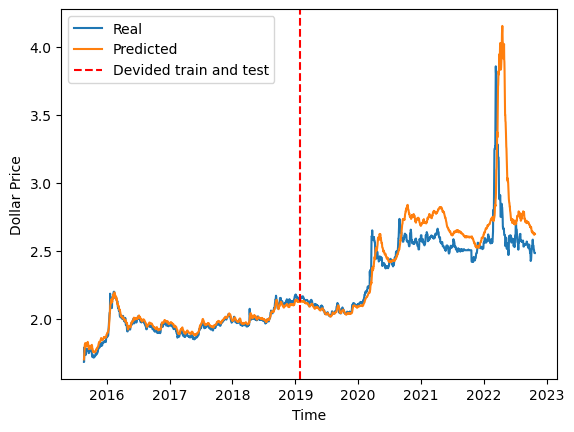

In [656]:
X_sequences = X.reshape(X.shape[0], 1, X.shape[1])
y_predicted = regressor.predict(X_sequences)
plt.plot(data.loc[sequence_length:, 'date'], scaler.inverse_transform(y),label = 'Real')
plt.plot(data.loc[sequence_length:, 'date'], scaler.inverse_transform(y_predicted), label = 'Predicted')
plt.axvline(x=data.loc[training_time_steps, 'date'], color='r', linestyle='--', label= 'Devided train and test')
plt.xlabel('Time')
plt.ylabel('Dollar Price')
plt.legend()
plt.show()